<h1 style="text-align: center;">Hit Analyzer</h1>
<h2 style="text-align: center;">By: Thomas Giewont, Shreyas Vaidya, and Thomas Varano</h2>

<br>
<h3 style="text-align: center;">Introduction</h3>
<p> This is the Introduction. </p>

<h3 style="text-align: center;">Imports and Data Setup</h3>

In [149]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
import json

<h3 style="text-align: center;">Data Collection and Curation</h3>

In [150]:
df = pd.read_csv('https://query.data.world/s/aofqalvgkuabshmmlxm32rxk3t3yiq')

In [151]:
df = df.drop(columns=['url'])
df = df.rename(columns={'WeekID': 'week', 'Week Position': 'week_position', 'Song': 'song', 'Performer': 'performer', 'SongID': 'songid', 'Instance': 'instance', 'Previous Week Position': 'prev_week_position', 'Peak Position': 'peak_position', 'Weeks on Chart': 'weeks_on_chart'})

In [152]:
df = df.astype({"week": 'datetime64'})

In [153]:
# stuff after 2000... obvi remove
df = df[df.week > pd.to_datetime(datetime.date(2000, 1, 1))]


In [154]:
# make a copy incase we fuck some data
dfcpy = df.copy()

In [155]:
# restore df
df = dfcpy.copy()

<h3 style="text-align: center;">Data Analysis</h3>

#### Hypothesis:
We believe that every song follows a similar trend when they reach the Billboard Top 100.

In [156]:
# remove weird nans
# tm = df.loc[:, df.columns != 'prev_week_position']
df = df.dropna(subset=['week', 'week_position', 'song', 'performer', 'songid', 'instance', 'peak_position', 'weeks_on_chart'])


In [157]:
# df = df.sample(frac=1/2)


In [158]:
# make dataframe to keep track of song-wide data

song_info = df.drop_duplicates(subset=['songid']).drop(columns=['week', 'week_position', 'instance', 'prev_week_position', 'peak_position', 'weeks_on_chart']).set_index('songid')
# song_info = pd.DataFrame(data=[tmp_df.songid, tmp_df.song, tmp_df.song])
# song_info = {s: {'song': r.song, 'performer': r.song} for s, r in tmp_df.iterrows()}

In [159]:
df

,week,week_position,song,performer,songid,instance,prev_week_position,peak_position,weeks_on_chart
17,2019-12-07,11,Dance Monkey,Tones And I,Dance MonkeyTones And I,1.0,19.0,11.0,8.0
22,2005-10-15,11,Run It!,Chris Brown,Run It!Chris Brown,1.0,24.0,11.0,8.0
27,2010-03-27,12,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,14.0,5.0,8.0
28,2018-04-07,12,Pray For Me,The Weeknd & Kendrick Lamar,Pray For MeThe Weeknd & Kendrick Lamar,1.0,10.0,7.0,8.0
34,2012-09-08,12,Blow Me (One Last Kiss),P!nk,Blow Me (One Last Kiss)P!nk,1.0,12.0,9.0,8.0
...,...,...,...,...,...,...,...,...,...
325690,2018-03-17,38,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,38.0,28.0,6.0
325691,2018-03-24,34,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,38.0,28.0,7.0
325692,2018-03-31,36,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,34.0,28.0,8.0
325693,2018-04-07,34,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,36.0,28.0,9.0


In [160]:
# get the absolute peak for each song
for s in list(song_info.index.values): 
    song_info.at[s, 'peak'] = min(df[df.songid == s].week_position.unique())

df = df[[(song_info.loc[r.songid].peak <= 10) for _, r in df.iterrows()]]
song_info = song_info[song_info.peak <= 10]


In [161]:
df

,week,week_position,song,performer,songid,instance,prev_week_position,peak_position,weeks_on_chart
17,2019-12-07,11,Dance Monkey,Tones And I,Dance MonkeyTones And I,1.0,19.0,11.0,8.0
22,2005-10-15,11,Run It!,Chris Brown,Run It!Chris Brown,1.0,24.0,11.0,8.0
27,2010-03-27,12,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,14.0,5.0,8.0
28,2018-04-07,12,Pray For Me,The Weeknd & Kendrick Lamar,Pray For MeThe Weeknd & Kendrick Lamar,1.0,10.0,7.0,8.0
34,2012-09-08,12,Blow Me (One Last Kiss),P!nk,Blow Me (One Last Kiss)P!nk,1.0,12.0,9.0,8.0
...,...,...,...,...,...,...,...,...,...
324811,2015-10-24,38,Same Old Love,Selena Gomez,Same Old LoveSelena Gomez,1.0,48.0,38.0,4.0
324859,2017-10-14,39,...Ready For It?,Taylor Swift,...Ready For It?Taylor Swift,1.0,34.0,4.0,4.0
324869,2011-01-08,39,Rocketeer,Far*East Movement Featuring Ryan Tedder,RocketeerFar*East Movement Featuring Ryan Tedder,1.0,41.0,39.0,4.0
324874,2003-04-05,39,Bring Me To Life,Evanescence Featuring Paul McCoy,Bring Me To LifeEvanescence Featuring Paul McCoy,1.0,43.0,39.0,4.0


In [162]:
# only keep the songs that peaked in the top 10
df = df.drop(columns=['peak_position'])


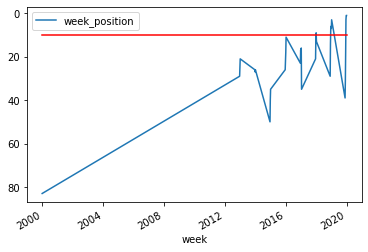

In [163]:
ax = plt.gca()
# for s in df.song.unique(): 
s = "All I Want For Christmas Is YouMariah Carey"
df[df.songid == s].plot(x='week', y='week_position', ax = ax)
horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
plt.plot(df[df.songid == s].week, horiz_line_data, 'r') 
plt.gca().invert_yaxis()
# print(min(pk))

In [164]:
# control points col
# (start, start_peak, end_peak, end)


In [165]:
# finding time before peak
# find when week_position == peak
# find the smallest weekid for my song
# subtract

# first hot week
# df.days_to_hot = np.nan


for s in df.songid.unique():

    song_instances = df[df.songid == s].sort_values(by='week')

    if len(song_instances[song_instances.week_position <= 10].week) != 0: 
        week = 1
        
        # get all peaks and their weeks
        # inflection points of graph in form: 
        # tuple (date, begin), where begin is true if the inflection point is beginning a hot spell
        inflections = []
        longest_peak = []

        # if the first week is already in the top 10
        if song_instances.iloc[0].week_position <= 10: 
            inflections.append((song_instances.iloc[0].week, True))


        for i in range(1, len(song_instances)): 
                
            if song_instances.iloc[i].week_position <= 10 and song_instances.iloc[i - 1].week_position > 10: 
                # this is for grace period
                if i > 1 and song_instances.iloc[i-2].week_position <= 10: 
                    # remove the last ending guy
                        inflections.remove(inflections[len(inflections) - 1])
                else: 
                    # if not beginning after a grace period, 
                    inflections.append((song_instances.iloc[i].week, True))
            elif song_instances.iloc[i].week_position > 10 and song_instances.iloc[i - 1].week_position <= 10:
                inflections.append((song_instances.iloc[i - 1].week, False))
   
        # if the song finished in the top 10 and dropped off the charts
        if song_instances.iloc[len(song_instances) - 1].week_position <= 10: 
            inflections.append((song_instances.iloc[len(song_instances) - 1].week, False))

        for i in range(0, len(inflections)-1):
            longest_date = datetime.timedelta(0)
            if len(inflections) == 0 or len(inflections) == 1:
                longest_peak = inflections
            else:
                # TODO look for better ways to find relevant peak (eg. height, top position, etc)
                if inflections[i][1] is True and inflections[i+1][1] is False:
                    if inflections[i+1][0] - inflections[i][0] >= longest_date:
                        longest_date = inflections[i+1][0] - inflections[i][0]
                        longest_peak = []
                        longest_peak.append(inflections[i])
                        longest_peak.append(inflections[i+1])

            # longest peak is relevant peak we care about

        song_info.loc[s, 'start_week'] = min(song_instances.week)
        song_info.loc[s, 'end_week'] = max(song_instances.week)
        song_info.loc[s, 'start_peak'] = longest_peak[0][0]
        song_info.loc[s, 'end_peak'] = longest_peak[1][0]
        # control_pts[s] = (min(song_instances.week), max(song_instances.week), longest_peak[0][0], longest_peak[1][0])
    
        
        # print(s)
        # print(longest_peak)         
                

In [166]:
# note we had to deal with prince popping back up on the charts after he died (and we might be dead by tomorrowsoko)
# dealt with those weirdly
# and then also guys that peaked one week and dipped

In [167]:
# make weeks to hot and weeks hot

for i, r in song_info.iterrows(): 
    song_info.loc[i, 'weeks_to_hot'] = (r.start_peak - r.start_week).days / 7
    song_info.loc[i, 'weeks_hot'] = (r.end_peak - r.start_peak).days / 7 + 1
    song_info.loc[i, 'tail_weeks'] = (r.end_week - r.end_peak).days / 7

song_info = song_info.astype({"weeks_to_hot": 'float', "weeks_hot": 'float', "tail_weeks": 'float'})


In [168]:
for i, r in df.iterrows(): 
    df.at[i, 'rel_week'] = (r.week - song_info.loc[r.songid, 'start_week']).days / 7

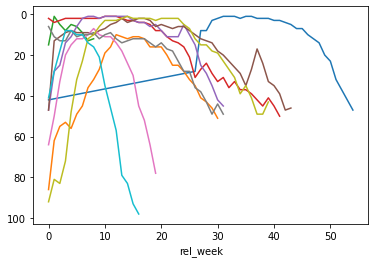

In [169]:
# a couple graphs to make pretty and look at
sngs = song_info.sample(n=10).index.values
ax = plt.gca()
tmp = df.sort_values(by='week')
for s in sngs: 
    tmp[tmp.songid == s].plot(x='rel_week', y='week_position', ax=ax)
plt.gca().invert_yaxis()
ax.get_legend().remove()
plt.show()

In [170]:
# More data points 

for s in df.songid.unique(): 
    song_inst = df[df.songid == s]

    # time above 10 total
    song_info.at[s, 'time_at_top_10'] = len(song_inst[song_inst.week_position <= 10])

    # slope of the climb
    # abs(start_peak position - start_week position)
    pos_climbed = abs(int(song_inst[song_inst.week == song_info.loc[s, 'start_peak']].week_position) - int(song_inst[song_inst.week == song_info.loc[s, 'start_week']].week_position))
    # if the song started on the chart, make the slope -1. else, make it (how many positions it climbed) / (how long the climb was)
    song_info.loc[s, 'climb_slope'] = -1 if song_info.loc[s, 'weeks_to_hot'] == 0 else (pos_climbed/song_info.loc[s, 'weeks_to_hot'])

    # slope of the tail (-1 if it just fell off the charts)
    # abs(end_peak position - end_week position)
    pos_lost = abs(int(song_inst[song_inst.week == song_info.loc[s, 'end_peak']].week_position) - int(song_inst[song_inst.week == song_info.loc[s, 'end_week']].week_position))
    song_info.loc[s, 'tail_slope'] = -1 if song_info.loc[s, 'tail_weeks'] == 0 else (pos_lost/song_info.loc[s, 'tail_weeks'])

    # average value
    song_info.at[s, 'avg_position'] = song_inst.week_position.mean()

    # weeks on chart
    song_info.at[s, 'weeks_on_chart'] = max(song_inst.weeks_on_chart)

    # instance
    song_info.at[s, 'instance'] = max(song_inst.instance)



In [194]:
df.insert(loc=len(df.columns), column='jump', value=[r.week_position - r.prev_week_position for _, r in df.iterrows()])

array([[<AxesSubplot:title={'center':'jump'}>]], dtype=object)

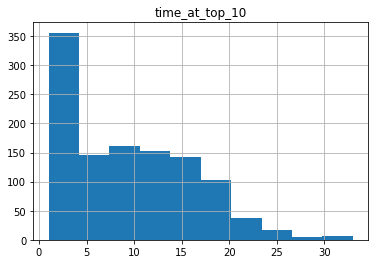

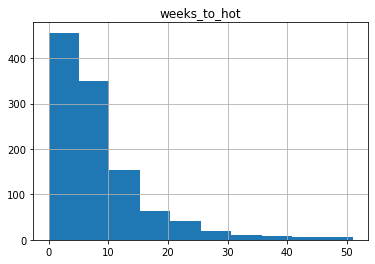

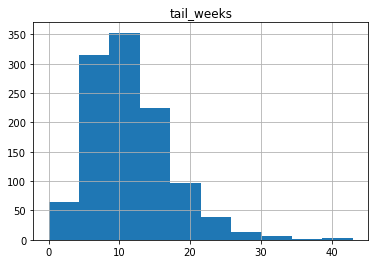

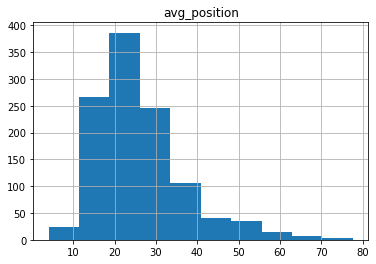

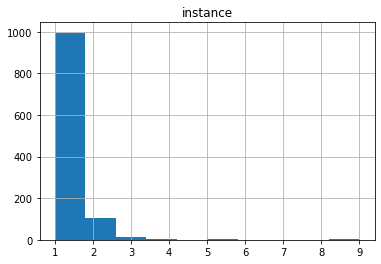

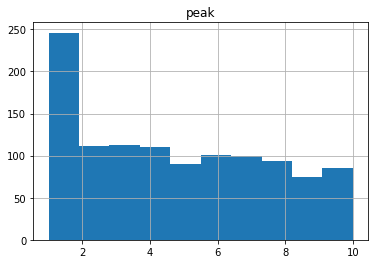

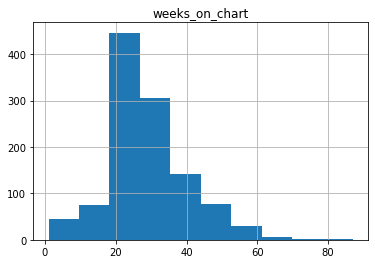

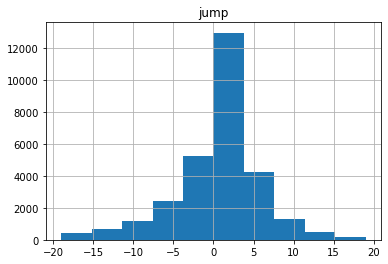

In [197]:
song_info.hist('time_at_top_10')
song_info[song_info.weeks_to_hot < 52].hist('weeks_to_hot')
song_info[song_info.tail_weeks < 52].hist('tail_weeks')
song_info.hist('avg_position')
song_info.hist('instance')
song_info.hist('peak')
song_info.hist('weeks_on_chart')
df[abs(df.jump) < 20].hist('jump')


In [191]:

df
# print(df[(df.songid == s) & (df.week == df.start_peak)].week_position)
# print(df[(df.songid == s) & (df.week == df.start_week)].week_position)

,week,week_position,song,performer,songid,instance,prev_week_position,weeks_on_chart,rel_week
63792,2000-01-08,9,Bring It All To Me,Blaque,Bring It All To MeBlaque,1.0,9.0,12.0,0.0
228047,2000-01-08,7,Auld Lang Syne,Kenny G,Auld Lang SyneKenny G,1.0,54.0,3.0,0.0
289310,2000-01-08,11,What A Girl Wants,Christina Aguilera,What A Girl WantsChristina Aguilera,1.0,11.0,7.0,0.0
59905,2000-01-08,43,Breathe,Faith Hill,BreatheFaith Hill,1.0,26.0,10.0,0.0
109554,2000-01-08,5,Hot Boyz,"Missy ""Misdemeanor"" Elliott Featuring NAS, EVE...","Hot BoyzMissy ""Misdemeanor"" Elliott Featuring ...",1.0,7.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...
167876,2019-12-28,20,No Guidance,Chris Brown Featuring Drake,No GuidanceChris Brown Featuring Drake,1.0,19.0,28.0,27.0
137066,2019-12-28,12,Lose You To Love Me,Selena Gomez,Lose You To Love MeSelena Gomez,1.0,13.0,9.0,8.0
125338,2019-12-28,27,HIGHEST IN THE ROOM,Travis Scott,HIGHEST IN THE ROOMTravis Scott,1.0,25.0,11.0,10.0
318055,2019-12-28,6,A Holly Jolly Christmas,Burl Ives,A Holly Jolly ChristmasBurl Ives,4.0,10.0,13.0,155.0


In [172]:
train = song_info.copy()[['peak', 'weeks_on_chart', 'weeks_hot', 'weeks_to_hot', 'instance', 'tail_weeks' ]]
train = train.reset_index().drop(columns=['songid'])

1126

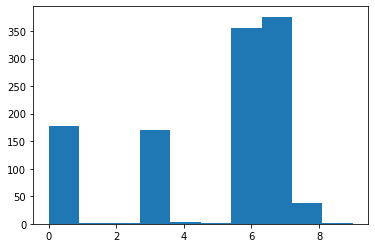

In [173]:
#Sets a random state so we get the same results every time
random_state = 170
#for now 
model = KMeans(n_clusters=10, random_state = random_state)
model.fit(train.to_numpy())
all_predictions = model.predict(train.to_numpy())
plt.hist(all_predictions)
len(all_predictions)

In [174]:
#assigns the cluster number to the train dataframe for each corresponding song
# for i,r in train.iterrows():
song_info.insert(len(song_info.columns), "group", all_predictions)

In [175]:
song_info

,song,performer,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks,time_at_top_10,climb_slope,tail_slope,avg_position,weeks_on_chart,instance,group
songid,,,,,,,,,,,,,,,,,
Dance MonkeyTones And I,Dance Monkey,Tones And I,9.0,2019-10-19,2019-12-28,2019-12-21,2019-12-21,9.0,1.0,1.0,1.0,9.666667,2.000000,33.818182,11.0,1.0,6
Run It!Chris Brown,Run It!,Chris Brown,1.0,2005-08-27,2006-05-13,2005-10-22,2006-02-11,8.0,17.0,13.0,17.0,10.500000,3.076923,22.368421,38.0,1.0,0
BabyJustin Bieber Featuring Ludacris,Baby,Justin Bieber Featuring Ludacris,5.0,2010-02-06,2010-06-19,2010-04-03,2010-04-24,8.0,4.0,8.0,5.0,0.625000,5.375000,22.000000,20.0,1.0,6
Pray For MeThe Weeknd & Kendrick Lamar,Pray For Me,The Weeknd & Kendrick Lamar,7.0,2018-02-17,2018-06-30,2018-02-17,2018-03-31,0.0,7.0,13.0,6.0,-1.000000,3.923077,21.250000,20.0,1.0,6
Blow Me (One Last Kiss)P!nk,Blow Me (One Last Kiss),P!nk,5.0,2012-07-21,2013-01-19,2012-09-22,2012-11-03,9.0,7.0,11.0,11.0,5.777778,3.363636,19.629630,27.0,1.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Edge Of GloryLady Gaga,The Edge Of Glory,Lady Gaga,3.0,2011-05-28,2011-11-05,2011-05-28,2011-08-13,0.0,12.0,12.0,11.0,-1.000000,3.333333,18.541667,24.0,1.0,7
The FoxYlvis,The Fox,Ylvis,6.0,2013-09-21,2014-01-18,2013-10-12,2013-11-09,3.0,5.0,10.0,5.0,7.000000,6.500000,44.944444,18.0,1.0,6
The Game Of LoveSantana Featuring Michelle Branch,The Game Of Love,Santana Featuring Michelle Branch,5.0,2002-10-05,2003-06-14,2002-11-02,2003-01-18,4.0,12.0,21.0,11.0,14.250000,1.904762,22.540541,37.0,1.0,0


In [176]:
#Gets averages for every cluster/group. This code is definitely not the most efficient way and I will probably redo
class Result:
    def __init__(self,peak, wc, wh, wth, inst, tail, group):
        self.peak = peak
        self.wc = wc
        self.wh = wh
        self.wth = wth
        self.inst = inst
        self.tail = tail
        self.group = group
        self.len = 1
    def add(self,peak, wc, wh, wth, inst, tail):
        self.peak += peak
        self.wc += wc
        self.wh += wh
        self.wth += wth
        self.inst += inst
        self.tail += tail
        self.len += 1
    def get(self):
        return {
            "peak": self.peak / self.len,
            "weeks_on_chart": self.wc / self.len,
            "weeks_hot" : self.wh / self.len,
            'weeks_to_hot' : self.wth / self.len,
            'instance' : self.inst / self.len,
            'tail_weeks' : self.tail / self.len,
            'group' : self.group,
            'length' : self.len
        }
    def display(self):
        v = self.get()
        return json.dumps(v)
cluster = {}
for i,r in song_info.iterrows():
    key = r.group
    if key in cluster:
        cluster[key].add(r.peak, r.weeks_on_chart, r.weeks_hot, r.weeks_to_hot, r.instance, r.tail_weeks)
    else:
        temp = Result(r.peak, r.weeks_on_chart, r.weeks_hot, r.weeks_to_hot, r.instance, r.tail_weeks, key)
        cluster[key] = temp

for c in cluster:
    print(cluster[c].display())

{"peak": 6.729577464788733, "weeks_on_chart": 17.861971830985915, "weeks_hot": 3.016901408450704, "weeks_to_hot": 4.653521126760563, "instance": 1.1098591549295775, "tail_weeks": 10.64225352112676, "group": 6, "length": 355}
{"peak": 2.6123595505617976, "weeks_on_chart": 43.91011235955056, "weeks_hot": 17.359550561797754, "weeks_to_hot": 8.567415730337078, "instance": 1.1404494382022472, "tail_weeks": 17.971910112359552, "group": 0, "length": 178}
{"peak": 2.827127659574468, "weeks_on_chart": 26.64627659574468, "weeks_hot": 12.422872340425531, "weeks_to_hot": 5.321808510638298, "instance": 1.0372340425531914, "tail_weeks": 8.694148936170214, "group": 7, "length": 376}
{"peak": 6.823529411764706, "weeks_on_chart": 31.988235294117647, "weeks_hot": 4.658823529411765, "weeks_to_hot": 18.123529411764707, "instance": 1.2470588235294118, "tail_weeks": 11.876470588235295, "group": 3, "length": 170}
{"peak": 4.351351351351352, "weeks_on_chart": 52.2972972972973, "weeks_hot": 6.297297297297297, 

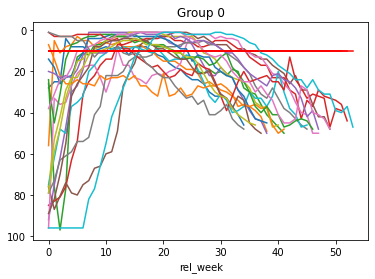

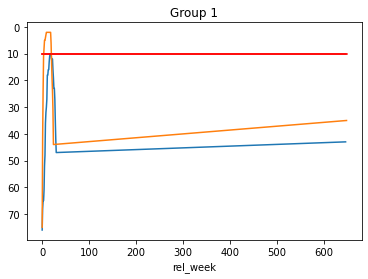

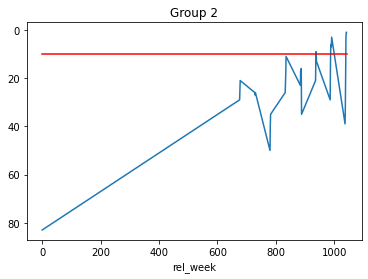

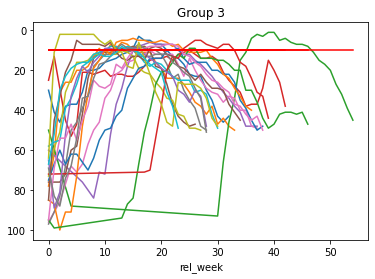

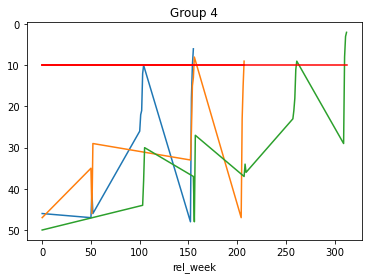

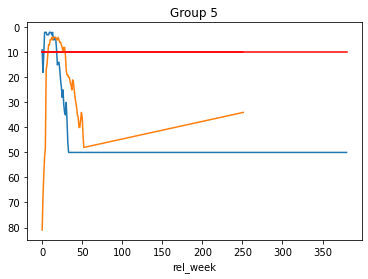

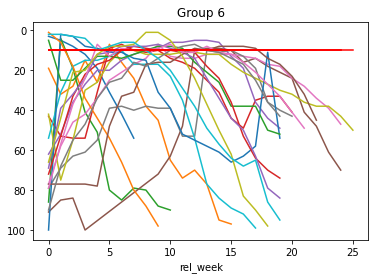

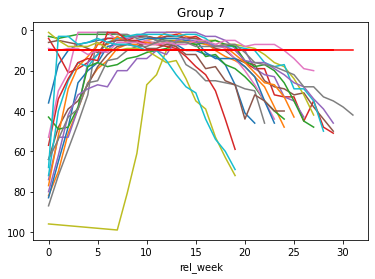

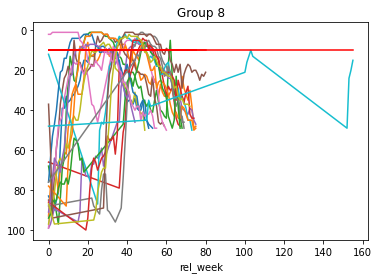

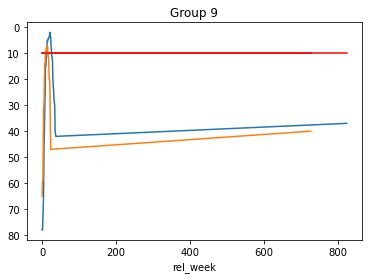

In [177]:
from random import sample
frames = {}
poop = [8,1,4,7]
for c in sorted(cluster):
    temp = song_info[song_info.group == c].index.values
    if len(temp) > 20:
        temp = sample(temp.tolist(),20)
    ax = plt.gca()
    df = df.sort_values(by='week')
    for s in temp:
    # for s in df.song.unique(): 
        df[df.songid == s].plot(x='rel_week', y='week_position', ax = ax)
        horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
        plt.plot(df[df.songid == s].rel_week, horiz_line_data, 'r') 
    plt.gca().invert_yaxis()
    ax.get_legend().remove()
    plt.title("Group " + str(c))
    plt.show()

In [178]:
song_info[song_info.group == 4]


,song,performer,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks,time_at_top_10,climb_slope,tail_slope,avg_position,weeks_on_chart,instance,group
songid,,,,,,,,,,,,,,,,,
A Holly Jolly ChristmasBurl Ives,A Holly Jolly Christmas,Burl Ives,6.0,2017-01-07,2019-12-28,2019-12-21,2019-12-28,154.0,2.0,0.0,3.0,0.233766,-1.0,27.153846,13.0,4.0,4
Jingle Bell RockBobby Helms,Jingle Bell Rock,Bobby Helms,8.0,2016-01-09,2019-12-28,2019-12-28,2019-12-28,207.0,1.0,0.0,2.0,0.183575,-1.0,26.615385,29.0,8.0,4
Rockin' Around The Christmas TreeBrenda Lee,Rockin' Around The Christmas Tree,Brenda Lee,2.0,2014-01-04,2019-12-28,2019-01-05,2019-12-28,261.0,52.0,0.0,4.0,0.157088,-1.0,26.578947,31.0,9.0,4


In [179]:
df[df.rel_week > 100]


,week,week_position,song,performer,songid,instance,prev_week_position,weeks_on_chart,rel_week
200840,2011-11-05,26,Good Life,OneRepublic,Good LifeOneRepublic,2.0,18.0,30.0,101.0
200874,2011-11-12,28,Good Life,OneRepublic,Good LifeOneRepublic,2.0,26.0,31.0,102.0
200906,2011-11-19,31,Good Life,OneRepublic,Good LifeOneRepublic,2.0,28.0,32.0,103.0
200939,2011-11-26,41,Good Life,OneRepublic,Good LifeOneRepublic,2.0,31.0,33.0,104.0
200964,2011-12-03,38,Good Life,OneRepublic,Good LifeOneRepublic,2.0,41.0,34.0,105.0
...,...,...,...,...,...,...,...,...,...
318231,2019-12-28,1,All I Want For Christmas Is You,Mariah Carey,All I Want For Christmas Is YouMariah Carey,9.0,1.0,35.0,1042.0
318226,2019-12-28,2,Rockin' Around The Christmas Tree,Brenda Lee,Rockin' Around The Christmas TreeBrenda Lee,9.0,3.0,31.0,312.0
202112,2019-12-28,9,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8.0,15.0,29.0,207.0
201981,2019-12-28,15,It's The Most Wonderful Time Of The Year,Andy Williams,It's The Most Wonderful Time Of The YearAndy W...,4.0,20.0,13.0,155.0


<AxesSubplot:xlabel='rel_week', ylabel='week_position'>

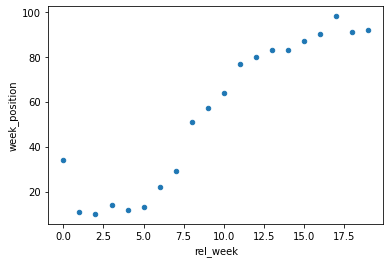

In [180]:
df[df.performer == 'Michael Jackson'].plot(x='rel_week', y='week_position', kind='scatter')

<h3 style="text-align: center;">Insights Attained</h3>